## User messages classification by categories

### Importing packages

In [315]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# nltk.download()

### Reading dataset and first grance 

In [316]:
dataset = pd.read_csv('data.csv')
dataset.head()

,Unnamed: 0,text,category,rank
0,0.0,8 hours,SLEEP,4
1,1.0,"Stress free today, until now bc the rain and d...",WATER,3
2,2.0,"Need to step it up, got a Greek salad wrap but...",FOOD,2
3,3.0,And I am going to dinner now,FOOD,3
4,4.0,9:30?,WORKOUT,Can't rate


The dataset has 4 columns (text - dependent variable and text - independent).

### Let's take a look at observable variable distribution.

In [317]:
dataset['category'].value_counts()

SLEEP         13793
FOOD           7752
STRESS         6886
WORKOUT        6235
WATER          5103
Can't rate        4
3                 2
Name: category, dtype: int64

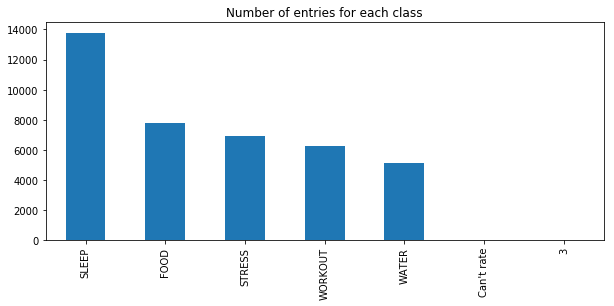

In [318]:
import matplotlib.pyplot as plt

classes = dataset.columns
plt.figure(figsize=(10,4))
plt.title("Number of entries for each class")
dataset['category'].value_counts().plot(kind='bar')

This data is a little bit imbalanced because there is a significant difference between number of "SLEEP" classes comparing to others. This may impact on model performance.

### Dropping columns that make no sense

In [319]:
for value in dataset['category'].unique():
    if value not in ['SLEEP', 'WATER', 'FOOD', 'WORKOUT', 'STRESS']:
        indexNames = dataset[dataset['category'] == value].index

dataset.drop(indexNames , inplace=True)

In [320]:
# classes
my_tags = ['SLEEP', 'WATER', 'FOOD', 'WORKOUT', 'STRESS']

In [321]:
dataset.isna().sum()

Unnamed: 0     4
text           0
category       6
rank          10
dtype: int64

There some missing values in this data.

### Dropping missing values 

In [322]:
dataset = dataset.dropna(axis=0)

### Final data shape (after EDA)

In [323]:
print(dataset.shape)
print(dataset['category'].unique())

(39769, 4)
['SLEEP' 'WATER' 'FOOD' 'WORKOUT' 'STRESS']


### Data overview

In [324]:
for i in dataset.loc[dataset['category'] == "WORKOUT"]['text']:
    print(i)

9:30?
Not yet still In Bed😬
Yes - 
Just finished 
Yes worked out 
Yes 
Good workout this morning 
No
No I did not workout today
Yes
Worked out - build
Yes
Good workout. 
5
No rest day 
Home just walked 3 miles 
Work out 
Good wkfkoht
Not yet
Did build 
Yes
Worked out - boost
Ya 
I decided I'm retired from "work" on Saturday and Sundays.  If it's fun then it's not work. 
This morning wasn't looking so good, was definitely having a mental issue witch was setting me up for derailment. Things got changed around in my workout, which made me look at the positive and I carried that attitude all day!
Yes, and it was great 
Didn't workout today. My back is hurting so taking a rest day
Yes 
Nope. Rest day 
7
Yes
No😑
No workout today...stretching!! Did a lot of hill walking yesterday and my knees are killing me 
32
No
Yes I worked out
Try my workout 
If u want to do a run instead 
Row bike run. Like a sprint tri
Yes 
Ran 6 miles 
Great
Of course 
8
No. Too sore for boxing.
Not today. 
Taking toda

Worked out hard
Yessss
Yup! Went to build 
Did not work out
Yes
Didn't workout today was planning too but didn't have time so I will more tomorrow 
I didn't workout today. I had an appt in the city and should have woken up early to do a morning workout 
No
No
Btw. Someone asked how much it would it cost to do Verb with. A weekly workout emailed?
Yes I worked out
2 great days in a row!!!
No
Didn't workout-no voice and sore throat
Did a few actual pushups. 
Could've been calmer.
Yes
The amount of steps carrying a kid may be as good as a workout 
I just got a quick workout in also. 
Yes
Yes
Yes! Build!
Tired lol have been on the plane since 9 Am
Didn't workout 
No
From Wednesday: no workout, rest day
I did work out - went to boost
Didn't sleep well - my daughter kept having bad dreams :( 
I will! Boost was good but interrupted by Ashley's car getting smashed and we only ended up doing 2 of the rounds (I did ski erg instead of bike, and the rower) so we could help her out. I'm going to do 

Workout at 430 today 
Yes
Worked out
Workout was good 
Not yet. I will later 
Working on it..... 
I got in a 2 mile walk/run
Little something 
Took more notes on writing.  
Better.: didn't work out hard enough 
No working out 
Yes 
But I did build! 
Ok. I worked out
Yes worked out - build 
Recovery day 
I woke up, not in a good place. Went for a a run and tried clearing shit up in my head. It was great, had a good run and tried clearing my head 
Yes! 
No :(
5am
Yes. I taught a class 
Didn't workout
Workout was good
Not yet 
Did a double today (cardio kickboxing plus boost/build). Relaxed and got a lot of rest. Ford choices were just ok but I usually loosen up a little on weekends. 
Didn't workout yesterday 
A few sips here and there... working out now will be sure to drink a ton tonight
Completed every workout with a positive mind. I could have executed on the burpees better
Just a tough week, fighting a virus 
Yes 
Recovery day
Yes
No
Taking today off to stretch and relax :)
I worked 

Yes
Yes
Good easy workout
8
Good. I did legs/glutes in the gym in my building. 
Wish I could have exercised.
Yup. Got a quick one in. Struggled to get going,but pushed
Highlight: was sick all day at aork and stayed there strong, could have worked out more but waa sick
Yes
Grief. I'm working through it now that I'm not on pills.
No
I did work out - went to boost
Didn't sleep well - my daughter kept having bad dreams :( 
I will! Boost was good but interrupted by Ashley's car getting smashed and we only ended up doing 2 of the rounds (I did ski erg instead of bike, and the rower) so we could help her out. I'm going to do some burpees later...
Hey what does "50 burpees for time" mean?
I did the 100 squats this afternoon.
Yes boost 
Great workouts. 

Shitty time management with work 
Yes. CrossFit 
Playing 18 and walking 
No
Workout yes
Not yet, on my way 
I worked out 
I should leave work 
Yes
I worked out
Yes 
Yes
Fun
Took fewer drugs!
Still took some :(
Yes
Yes 
I made phone calls at wor

This is for better data understanding. In future this might help us generate new features for better classification.

### Text Pre-processing
For this particular dataset, our text cleaning step includes remove stop words, change text to lower case and so on.


In [325]:

STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

dataset['text'] = dataset['text'].apply(clean_text)


### Changing observable column data type to string

In [326]:
dataset['text'] = dataset['text'].astype(str)

### Train vs. Test split with 80 - 20 percentage.

In [327]:
from sklearn.model_selection import train_test_split

X = dataset.text
y = dataset.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [328]:
#x_train = x_train.transpose()

### Naive Bayes Classifier for Multinomial Models
We will start with a Naive Bayes classifier, which provides a nice baseline for this task. To make the vectorizer => transformer => classifier easier to work with, we will use Pipeline class in Scilkit-Learn that behaves like a compound classifier.

In [329]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report


nb = Pipeline([('vect', CountVectorizer(lowercase=False)),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

accuracy 0.9027742854748135
              precision    recall  f1-score   support

       SLEEP       0.92      0.91      0.92      2303
       WATER       0.88      0.96      0.92      4201
        FOOD       0.97      0.89      0.93      2021
     WORKOUT       0.96      0.89      0.92      1506
      STRESS       0.82      0.80      0.81      1900

    accuracy                           0.90     11931
   macro avg       0.91      0.89      0.90     11931
weighted avg       0.90      0.90      0.90     11931



This model returned 90% accuracy which is a good results but we will try some other approaches for this problem.

### Linear Support Vector Machine
Linear Support Vector Machine is widely regarded as one of the best text classification algorithms.

In [330]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.8661470119855837
              precision    recall  f1-score   support

       SLEEP       0.93      0.85      0.89      2303
       WATER       0.78      0.96      0.86      4201
        FOOD       0.98      0.87      0.92      2021
     WORKOUT       0.96      0.82      0.88      1506
      STRESS       0.85      0.71      0.77      1900

    accuracy                           0.87     11931
   macro avg       0.90      0.84      0.87     11931
weighted avg       0.88      0.87      0.87     11931



We achieve a lower accuracy score of 86% which is almost 4% worse than Naive Bayes.

### Logistic Regression
Logistic regression is a simple and easy to understand classification algorithm, and Logistic regression can be easily generalized to multiple classes.


In [331]:
from sklearn.linear_model import LogisticRegression

# balancing data
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, class_weight='balanced')),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

/Users/andrianhevalo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/andrianhevalo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.9167714357555947
              precision    recall  f1-score   support

       SLEEP       0.93      0.92      0.92      2303
       WATER       0.91      0.96      0.94      4201
        FOOD       0.96      0.93      0.94      2021
     WORKOUT       0.93      0.92      0.93      1506
      STRESS       0.85      0.81      0.83      1900

    accuracy                           0.92     11931
   macro avg       0.92      0.91      0.91     11931
weighted avg       0.92      0.92      0.92     11931



LG performed the best for this data with over 91% accuracy on test data. Let's take a look at confusion matrix.

Text(0.5, 15.0, 'Predicted label')

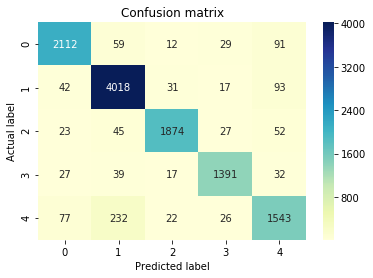

In [332]:
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Saving model to the directory

In [333]:
import pickle

filename = 'logistic_regression.sav'
pickle.dump(logreg, open(filename, 'wb'))

### Loading model

In [334]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
loaded_model.predict(["i want to drink"])

array(['WORKOUT'], dtype=object)